## Import Semua Packages/Library yang Digunakan

In [ ]:
pip install tensorflowjs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from PIL import Image
import tensorflowjs as tfjs
from sklearn.metrics import classification_report, confusion_matrix



## Data Preparation

### Data Loading

In [ ]:
# Direktori dataset
train_dir = "/content/drive/MyDrive/Submission_4/dataset/training_set"
test_dir = "/content/drive/MyDrive/Submission_4/dataset/test_set"

### Data Preprocessing

#### Augmentasi data

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)




#### Split data

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

# Menampilkan kelas yang terdeteksi
print("Classes:", train_generator.class_indices)
print("Classes:", val_generator.class_indices)
print("Classes:", test_generator.class_indices)


Found 9984 images belonging to 3 classes.
Found 2495 images belonging to 3 classes.
Found 2535 images belonging to 3 classes.
Classes: {'cats': 0, 'dogs': 1, 'tigers': 2}
Classes: {'cats': 0, 'dogs': 1, 'tigers': 2}
Classes: {'cats': 0, 'dogs': 1, 'tigers': 2}


## Modelling

In [ ]:
# Membangun model Sequential
model = Sequential([
    # Layer Konvolusi 1
    Conv2D(32, (5,5), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Layer Konvolusi 2
    Conv2D(64, (5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Layer Konvolusi 3
    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    # Global Average Pooling (mengganti Flatten)
    GlobalAveragePooling2D(),


    # Fully Connected Layer
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.25),  # Dropout untuk mencegah overfitting,

    # Layer Output (Softmax untuk klasifikasi banyak kelas)
    Dense(3, activation='softmax')  # Ubah angka 3 sesuai jumlah kelas dataset
])

# Menampilkan ringkasan model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 124, 124, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 58, 58, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 276,483 (1.05 MB)

 Trainable params: 276,035 (1.05 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Kompilasi model
initial_learning_rate = 0.001  # Mulai dari 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=2000, decay_rate=0.9, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
class CustomEarlyStopping(Callback):
    def __init__(self, accuracy_threshold=0.95, loss_threshold=0.05):
        super(CustomEarlyStopping, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.loss_threshold = loss_threshold
        self.best_val_acc = 0  # Menyimpan akurasi terbaik
        self.best_weights = None  # Menyimpan bobot terbaik

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")

        # Pastikan val_accuracy ada sebelum mengecek kondisi
        if val_acc is not None and val_loss is not None:
            if val_acc >= self.accuracy_threshold or val_loss <= self.loss_threshold:
                print(f"\nStopping training: val_accuracy ({val_acc:.4f}) >= {self.accuracy_threshold} "
                        f"or val_loss ({val_loss:.4f}) <= {self.loss_threshold}")
                self.model.stop_training = True

            # Simpan model terbaik berdasarkan akurasi
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        # Restore model ke bobot terbaik jika ada
        if self.best_weights is not None:
            print("\nRestoring model to best weights based on validation accuracy.")
            self.model.set_weights(self.best_weights)


In [ ]:
callbacks = [
    CustomEarlyStopping(accuracy_threshold=0.95, loss_threshold=0.05),
]


In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)



Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 828s 3s/step - accuracy: 0.5437 - loss: 0.8988 - val_accuracy: 0.3940 - val_loss: 1.1758
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 0.6552 - loss: 0.7215 - val_accuracy: 0.5419 - val_loss: 0.9896
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.6830 - loss: 0.6589 - val_accuracy: 0.5571 - val_loss: 1.0384
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - accuracy: 0.7071 - loss: 0.6073 - val_accuracy: 0.6870 - val_loss: 0.6724
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 726s 2s/step - accuracy: 0.7315 - loss: 0.5682 - val_accuracy: 0.5443 - val_loss: 1.5103
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - accuracy: 0.7475 - loss: 0.5425 - val_accuracy: 0.5832 - val_loss: 1.0178
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 732s 2s/step - accuracy: 0.7754 - loss: 0.4876 - val_accuracy: 0.7331 - val_loss: 0.5835
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.7819 - loss: 0.4759 - val_accu

## Evaluasi dan Visualisasi

In [ ]:
# Evaluasi model pada data training
train_loss, train_acc = model.evaluate(train_generator)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 252s 805ms/step - accuracy: 0.8999 - loss: 0.2432
Train Accuracy: 89.33%
Train Loss: 0.2531


In [ ]:
# Evaluasi model pada data testing
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


80/80 ━━━━━━━━━━━━━━━━━━━━ 688s 9s/step - accuracy: 0.8959 - loss: 0.2384
Test Accuracy: 89.55%
Test Loss: 0.2393


In [ ]:


# Mendapatkan prediksi dari model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = test_generator.classes  # Label asli

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_labels = list(test_generator.class_indices.keys())  # Label kelas
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))


80/80 ━━━━━━━━━━━━━━━━━━━━ 74s 914ms/step
Confusion Matrix:
 [[295 260 290]
 [293 277 275]
 [323 247 275]]
Classification Report:
               precision    recall  f1-score   support

        cats       0.32      0.35      0.34       845
        dogs       0.35      0.33      0.34       845
      tigers       0.33      0.33      0.33       845

    accuracy                           0.33      2535
   macro avg       0.33      0.33      0.33      2535
weighted avg       0.33      0.33      0.33      2535



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


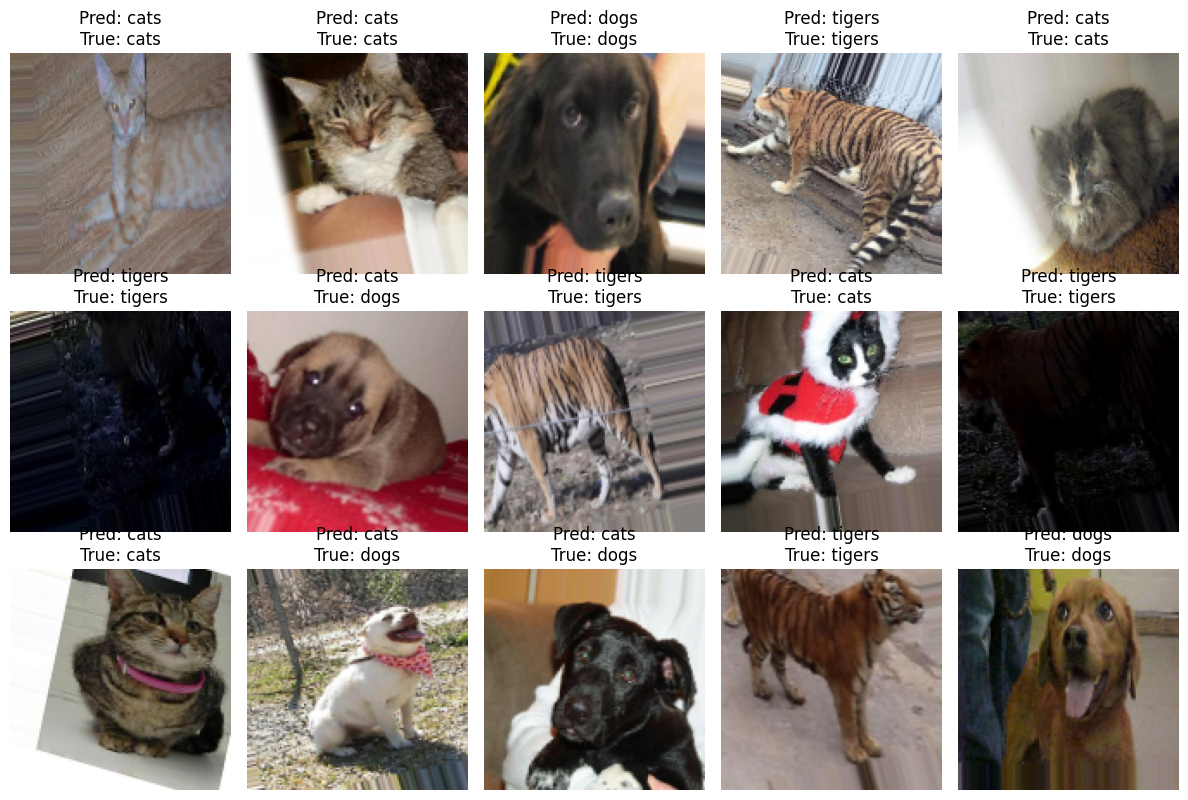

In [ ]:
# Mengambil beberapa gambar dari validation set
x_test, y_test = next(test_generator)
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Menampilkan gambar dan prediksinya
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
axes = axes.ravel()

for i in range(15):  # Menampilkan 15 gambar
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Pred: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_classes[i]]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


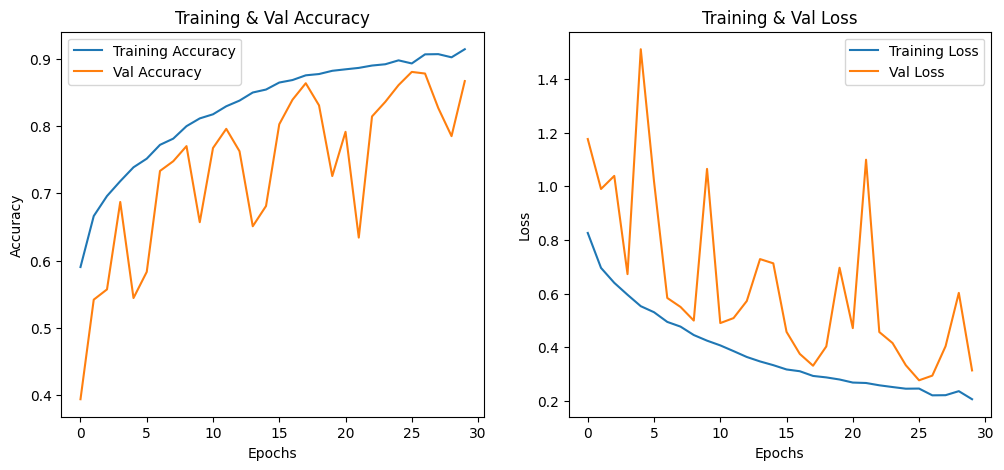

In [41]:

# Plot akurasi dan loss
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Val Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Val Loss')

plt.show()


## Konversi Model

#### Saved Model

In [ ]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137135024255440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024254288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024254480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024253712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024257168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024254096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024253328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024251408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024252944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024256016:

#### TF-Lite

In [ ]:
# Konversi model langsung ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model dalam format TF-Lite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TF-Lite dan disimpan sebagai 'model.tflite'")

Saved artifact at '/tmp/tmpx8zmg_vr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137135024255440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024254288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024254480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024253712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024257168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024254096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024253328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024251216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024251408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137135024252944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13713502425

#### TF-Js

In [ ]:
# Override np.bool agar tensorflowjs tidak error
if not hasattr(np, 'bool'):
    np.bool = bool


# Konversi model ke format TFJS
tfjs.converters.save_keras_model(model, "tfjs_model")


failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [ ]:
# Load model TF-Lite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
print("Model TF-Lite berhasil dimuat!")

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Model TF-Lite berhasil dimuat!


In [ ]:
# Dapatkan indeks input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"Input Shape: {input_details[0]['shape']}")
print(f"Output Shape: {output_details[0]['shape']}")


Input Shape: [  1 128 128   3]
Output Shape: [1 3]


In [ ]:
import random
# Pilih gambar secara acak dari folder
img_dir = "/content/drive/MyDrive/Submission_4/dataset/test_set/dogs"

# Filter hanya file gambar
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pastikan ada gambar dalam folder
if len(image_files) == 0:
    raise ValueError("Tidak ada gambar dalam folder test_set!")

# Pilih gambar secara acak
random_image = random.choice(image_files)
img_path = os.path.join(img_dir, random_image)

# Load dan ubah ukuran gambar
img = Image.open(img_path).resize((128, 128))

# Konversi gambar ke array numpy dan normalisasi
img_array = np.array(img, dtype=np.float32) / 255.0  # Normalisasi ke [0,1]

# Pastikan input memiliki dimensi (1, height, width, channels)
if img_array.shape[-1] != 3:
    raise ValueError(f"Expected 3 channels, but got {img_array.shape[-1]} channels")

img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension

print(f"Berhasil memuat gambar: {img_path}")
print(f"Shape gambar setelah preprocessing: {img_array.shape}")


Berhasil memuat gambar: /content/drive/MyDrive/Submission_4/dataset/test_set/dogs/dog.4601.jpg
Shape gambar setelah preprocessing: (1, 128, 128, 3)


In [ ]:
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Jalankan inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print(f"Prediksi kelas: {predicted_class}")
print(f"Probabilitas kelas: {output_data}")

Prediksi kelas: 1
Probabilitas kelas: [[0.26509154 0.7334752  0.00143324]]


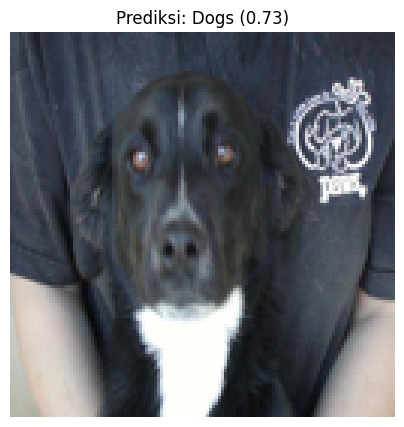

Prediksi kelas: Dogs
Probabilitas kelas: [[0.26509154 0.7334752  0.00143324]]


In [ ]:
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Jalankan inference
interpreter.invoke()

# Ambil hasil output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

# Daftar label kelas (ubah sesuai dataset)
class_labels = ["Cats", "Dogs", "Tigers"]

# Tampilkan hasil prediksi
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]} ({output_data[0][predicted_class]:.2f})")
plt.show()

print(f"Prediksi kelas: {class_labels[predicted_class]}")
print(f"Probabilitas kelas: {output_data}")
